<a href="https://colab.research.google.com/github/waltergkaturuza/Machine-Learning-for-Climate-and-Weather/blob/main/precipitation_downscaling_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

In many applications, we get precipitation fields at lower resolution than we need. For example, climate models usually have resolution in the tens of kilometers. This makes it difficult to study the effects of climatic change on extreme precipitation, which usually happens at shorter length scales. To remedy this, we can use downscaling: statistical methods that create higher-resolution fields from low-resolution inputs. These are related to the so-called super-resolution methods in image processing.

Generative Adversarial Networks are naturally suited for downscaling because they can learn to create realistic-looking outputs. In this notebook, we'll use TensorFlow/Keras to build a simple conditional GAN for downscaling radar-measured precipitation fields. You can train the GAN yourself, or if you prefer, you can jump straight into generating fields yourself.

This notebook is based on the research article "Stochastic Super-Resolution for Downscaling Time-Evolving Atmospheric Fields With a Generative Adversarial Network", which used a dataset from the MeteoSwiss radar network. To make the dataset a more manageable size and reduce the cost of training, the time dimension used in that paper has been removed, the sample size reduced to 32x32, 64000 training samples have been randomly selected from the dataset.



# **Getting started**

To work with this notebook, you'll need it to run in an environment with TensorFlow, NumPy, Matplotlib and NetCDF4 installed. You should also have a GPU available. One option is to run this on Google Colab, where these packages are already installed, except netCDF4, which can be installed by running the code in the cell below. If using Colab, go to Edit -> Notebook settings -> Hardware accelerator and select "GPU".

In [1]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.5 MB/s eta 0:00:00


# **Setting up the data**

Loading the high-resolution data

We start by downloading the precipitation data and reading it to memory.

In [2]:
import netCDF4
import numpy as np

# Download data to our local directory
!wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/scale_rzc.txt
!wget https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/samples-2018-32x32.nc

# Load the samples
with netCDF4.Dataset("samples-2018-32x32.nc", 'r') as ds:
    samples = np.array(ds["samples"][:], copy=False)

# the original data is in an 8-bit format that needs to be scaled
scale = np.loadtxt("scale_rzc.txt").astype(np.float32)
samples = scale[samples]

# convert missing data to zeros
samples[~np.isfinite(samples)] = 0

# Do a log-transformation to reduce dynamic range.
# We threshold data to 0.1 mm/h and set everything below to 0.02 mm/h
# to allow the log-transformation to work.
samples[samples < 0.1] = 0.02 
samples = np.log10(samples)

--2023-04-26 12:14:39--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/scale_rzc.txt
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.180.32
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.180.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283 (3.2K) [text/plain]
Saving to: ‘scale_rzc.txt’

scale_rzc.txt       100%[===================>]   3.21K  --.-KB/s    in 0s      

2023-04-26 12:14:40 (262 MB/s) - ‘scale_rzc.txt’ saved [3283/3283]

--2023-04-26 12:14:40--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/samples-2018-32x32.nc
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.180.32
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.180.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16538709 (16M) [application/x-netcdf]
Saving to: ‘samples-2018-32x32.nc’

samples-2018-32x32. 100%[===================>]  

**Creating input datasets**

For this demonstration work, we simply create the low-resolution samples by spatially averaging our high-resolution samples. We use a 4x4 size for the low resolution, so our downscaling will have a resolution multiplier of 8. Then we pack both the high-resolution and low-resolution data in a TensorFlow Dataset.

If you see an ImportError while running the code, make sure you have TensorFlow installed in your notebook environment. For instance, on Google Colab you'll need to switch to a GPU node (see the Getting started" section).

In [3]:
import tensorflow as tf

rf = 8 # resolution factor

# Create low-resolution (LR) array
lr_shape = (
    samples.shape[0], samples.shape[1]//rf,
    samples.shape[2]//rf, samples.shape[3]
)

# 8x8 average pooling
samples_lr = np.zeros(lr_shape, samples.dtype)
for i in range(rf):
    for j in range(rf):
        samples_lr += samples[:,i::rf,j::rf,:]
samples_lr /= rf**2

# set aside 10% of data for testing (not used to train model)
indices = np.arange(samples.shape[0])
rng = np.random.RandomState(seed=1)
rng.shuffle(indices)
N_testing = int(samples.shape[0]*0.1)
samples_test = samples[indices[:N_testing],...]
samples = samples[indices[N_testing:],...]
samples_lr_test = samples_lr[indices[:N_testing],...]
samples_lr = samples_lr[indices[N_testing:],...]

# create TensorFlow Dataset for training
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((samples_lr, samples))
dataset = dataset.shuffle(buffer_size=256).batch(batch_size)

**Plotting the data**
Let's take a quick look at the data. First, we define some functions for plotting using Matplotlib.

In [4]:
from matplotlib import colors, gridspec, pyplot as plt

def plot_precip(ax, logR):
    """ Plot a single precipitation image.
    """
    if logR.ndim == 3:
        logR = logR[:,:,0] # remove channels dimension
    R = 10**logR
    R[R < 0.1] = np.nan
    ax.imshow(R, norm=colors.LogNorm(0.1,100,clip=True))
    ax.tick_params(left=False, bottom=False,
        labelleft=False, labelbottom=False)

def plot_samples(samples, labels=None):
    """ Plot a grid with many images.
    """
    N_variables = len(samples)
    N_samples = len(samples[0])
    fig = plt.figure(figsize=(N_samples*1.5, N_variables*1.5))
    gs = gridspec.GridSpec(N_variables, N_samples, hspace=0.02, wspace=0.02)

    for (i,variable) in enumerate(samples):
        for (j,sample) in enumerate(variable):
            ax = fig.add_subplot(gs[i,j])
            plot_precip(ax, sample)
            if (j == 0) and (labels is not None):
                ax.set_ylabel(labels[i])

    fig.show()

Then, we pick a few interesting examples from the test dataset and show both the high- and low-resolution versions.

If you want to explore the dataset more, change the indices variable or uncomment the lines that pick the indices randomly.

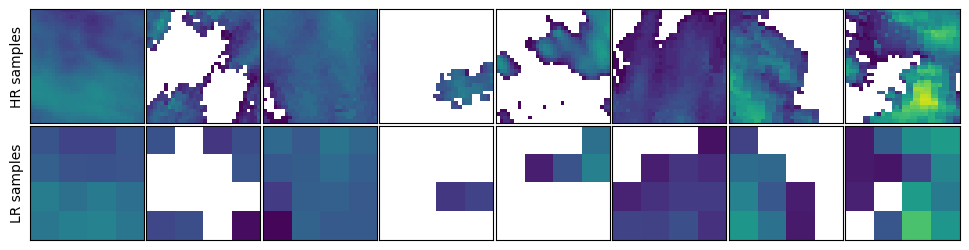

In [5]:
# Show a selection of interesting samples from the test set
indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
# rng = np.random.RandomState(seed=4)
# indices = rng.choice(samples_test.shape[0], 8, replace=False)

plot_samples(
    [samples_test[indices,...], samples_lr_test[indices,...]],
    labels=["HR samples", "LR samples"]
)

**Creating the GAN**

**GAN networks**


Here, we create the generator and discriminator networks. We use a fairly simple upsampling convolutional neural network (ConvNet) for the generator and a downsampling ConvNet for the discriminator.

In [6]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate, Conv2D, Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, UpSampling2D


def create_generator(
    block_widths=(128,64,32),
    input_shape=(4,4,1),
    noise_shape=(4,4,8)
):
    # inputs (concatenated)
    input_lr = Input(shape=input_shape)
    input_noise = Input(shape=noise_shape)
    x = Concatenate()([input_lr, input_noise])

    x = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same'
    )(x)
    x = LeakyReLU(0.2)(x)
    # upsampling stages
    for width in block_widths:
        x = UpSampling2D(interpolation='bilinear')(x)
        x = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x)
        x = LeakyReLU(0.2)(x)

    # final projection to output space
    output = Conv2D(1, kernel_size=(1,1))(x)

    return Model(inputs=[input_lr, input_noise], outputs=output)


def create_discriminator(
    block_widths=(32,64,128),
    input_shape_hr=(32,32,1),
    input_shape_lr=(4,4,1),
    postproc_convs=2,
    output_activation='linear' # 'linear' when using 'from_logits' in loss
):
    # inputs
    input_hr = Input(shape=input_shape_hr)
    input_lr = Input(shape=input_shape_lr)

    # Convolution steps for both HR and LR inputs
    x_hr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_hr)
    x_hr = LeakyReLU(0.2)(x_hr)
    x_lr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_lr)
    x_lr = LeakyReLU(0.2)(x_lr)
    for width in block_widths:
        x_hr = Conv2D( # downsample HR samples on each loop
            width, kernel_size=(3,3), padding='same', strides=2,
        )(x_hr)
        x_hr = LeakyReLU(0.2)(x_hr)
        x_lr = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x_lr)
        x_lr = LeakyReLU(0.2)(x_lr)

    # Concatenate HR and LR branches and do some joint processing
    x = Concatenate()([x_hr, x_lr])
    for _ in range(postproc_convs):
        x = Conv2D(block_widths[-1], kernel_size=(3,3), padding='same')(x)
        x = LeakyReLU(0.2)(x)

    # Pool to get outputs
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation=output_activation)(x)

    return Model(inputs=[input_lr, input_hr], outputs=output)


generator = create_generator()
discriminator = create_discriminator()

In [7]:
# Print summaries of the model
generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 4, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4, 4, 8)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 4, 4, 9)      0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 4, 4, 128)    10496       ['concatenate[0][0]']        

**GAN training loop**

We create a custom Keras model for the GAN logic. We override train_step to implement the nonstandard GAN training procedure.

In [8]:
# Adapted from https://keras.io/examples/generative/conditional_gan/

class DownscalingGAN(Model):
    def __init__(self, discriminator, generator, noise_shape=(4,4,8)):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_shape = noise_shape
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.step_number = tf.Variable(0)

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        (samples_lr, samples_hr) = data

        # Sample noise for the generator.
        batch_size = tf.shape(samples_hr)[0]
        noise = tf.random.normal(
            shape=(batch_size,)+self.noise_shape
        )

        def train_discriminator():
            # Generate fake samples.
            samples_gen = self.generator([samples_lr, noise])

            # Combine them with real images.
            combined_samples_hr = tf.concat([samples_gen, samples_hr], axis=0)
            combined_samples_lr = tf.concat([samples_lr, samples_lr], axis=0)

            # Assemble labels discriminating real from fake images.
            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )

            # Train the discriminator.
            with tf.GradientTape() as tape:
                predictions = self.discriminator(
                    [combined_samples_lr, combined_samples_hr]
                )
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

            # Monitor loss.
            self.disc_loss_tracker.update_state(d_loss)

        def train_generator():
            # Create labels that say "all real images".
            misleading_labels = tf.zeros((batch_size, 1))

            # Train the generator (note that we should *not* update the weights
            # of the discriminator)!
            with tf.GradientTape() as tape:
                samples_gen = self.generator([samples_lr, noise])
                predictions = self.discriminator([samples_lr, samples_gen])
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )

            # Monitor loss.
            self.gen_loss_tracker.update_state(g_loss)
        
        # If we trained the generator now, train the discriminator next
        # or vice versa.
        
        tf.cond(
            self.step_number % 2 == 0,
            train_discriminator,
            train_generator
        )        
        self.step_number.assign(self.step_number+1)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

gan = DownscalingGAN(discriminator, generator)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

**Training the GAN**


Now, training the GAN is really simple! We start it just like we would any Keras model training - with a call to fit.

We train for 30 epochs which should be enough to get reasonable looking results in about 15 minutes. To train more, you can increase epochs - or just run the cell below again.

While your waiting for the GAN to train, you can take some time to **watch the video** belonging to this lesson.

In [ ]:
gan.fit(dataset, epochs=30)

Epoch 1/30
623/900 [===================>..........] - ETA: 3:38 - g_loss: 0.9779 - d_loss: 0.6979

**Examining the results**

**Plotting generated samples **

With our GAN trained, we can now create some downscaled precipitation fields! Run the code below to do this.

In [ ]:
rng = np.random.RandomState(seed=15)
num_samples = 8

# Selection of interesting samples from the test set
indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
# indices = rng.choice(samples.shape[0], num_samples, replace=False)

noise = rng.randn(num_samples, 4, 4, 8)
samples_gen_1 = generator.predict_on_batch(
    [samples_lr_test[indices,...], noise]
)
noise = rng.randn(num_samples, 4, 4, 8)
samples_gen_2 = generator.predict_on_batch(
    [samples_lr_test[indices,...], noise]
)
plot_samples(
    [
        samples_lr_test[indices,...], samples_test[indices,...], 
        samples_gen_1, samples_gen_2    
    ],
    labels=["LR samples", "HR samples", "Gen. samples 1", "Gen. samples 2"]
)

The first row shows the low-resolution precipitation samples, the next shows the real high-resolution precipitation, and the bottom two rows show downscaled fields from the GAN. We can see that the GAN creates reasonable guesses of what the high-resolution precipitation fields might look like. If you look at the generated images more closely, you'll also see that there are small differences in the two GAN-generated fields. This means that our GAN is generating solutions stochastically - you'll get a different guess every time.

**Optional homework**

Here are some suggestions if you'd like to spend some more time to study the GAN in more detail:

Train the GAN longer (increase epochs in gan.fit and see if the generated results get better).
Try to adjust the generator and discriminator architectures and see what effect it has on the images.